In [65]:
use_cupy = False
use_naive = True

if use_cupy:
    import cupy as np
else:
    import numpy as np
# import cupy as np
import numpy as real_np
import argparse
import matplotlib.pyplot as plt
#import gt4py


In [66]:
# Initialize model parameters
M = 512 # args.M
N = 512 # args.N
M_LEN = M + 1
N_LEN = N + 1
L_OUT = True # args.L_OUT
VIS = True
VIS_DT=100
ITMAX = 4000
dt = 90.
tdt = dt
dx = 100000.
dy = 100000.
fsdx = 4. / (dx)
fsdy = 4. / (dy)
a = 1000000.
alpha = 0.001
el = N * dx
pi = 4. * np.arctan(1.)
tpi = 2. * pi
di = tpi / M
dj = tpi / N
dtheta = tpi / M
pcf = (pi * pi * a * a) / (el * el)
SIZE = M_LEN * N_LEN

# Model Variables
u = np.zeros((M_LEN, N_LEN))
v = np.zeros((M_LEN, N_LEN))
p = np.zeros((M_LEN, N_LEN))
unew = np.zeros((M_LEN, N_LEN))
vnew = np.zeros((M_LEN, N_LEN))
pnew = np.zeros((M_LEN, N_LEN))
uold = np.zeros((M_LEN, N_LEN))
vold = np.zeros((M_LEN, N_LEN))
pold = np.zeros((M_LEN, N_LEN))
uvis = np.zeros((M_LEN, N_LEN))
vvis = np.zeros((M_LEN, N_LEN))
pvis = np.zeros((M_LEN, N_LEN))
cu = np.zeros((M_LEN, N_LEN))
cv = np.zeros((M_LEN, N_LEN))
z = np.zeros((M_LEN, N_LEN))
h = np.zeros((M_LEN, N_LEN))
psi = np.zeros((M_LEN, N_LEN))


In [67]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline
    

def live_plot3(fu, fv, fp, title=''):
    clear_output(wait=True)
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 3), ncols=3)

    pos1 = ax1.imshow(fp, cmap='Blues', vmin=49999, vmax=50001,interpolation='none')
    ax1.set_title('p')
    pos2 = ax2.imshow(fu, cmap='Reds', vmin=-1, vmax=1,interpolation='none')
    ax2.set_title('u')
    pos3 = ax3.imshow(fv, cmap='Greens',vmin=-1, vmax=1,interpolation='none')
    ax3.set_title('v')

    fig.suptitle(title)
    #plt.xlabel('x')
    #plt.ylabel('y')
    plt.show()


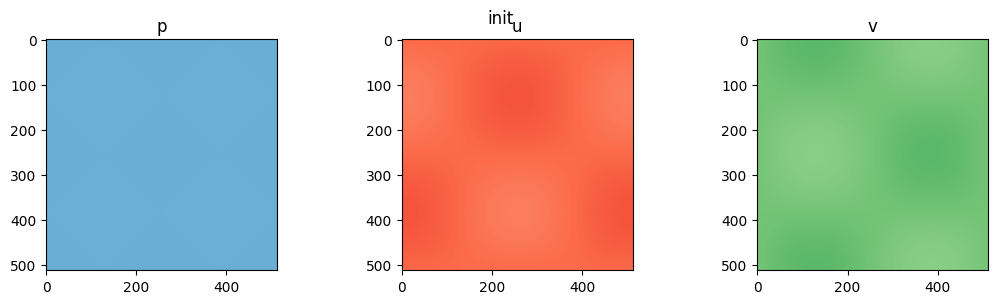

50000.00752991058
49999.99247008942
0.12271538285720328
-0.12271538285720328
0.12271538285720328
-0.12271538285720328


In [68]:
%matplotlib inline
# Initial values of the stream function and p

if use_naive:
    for i in range(M + 1):
        for j in range(N + 1):
            psi[i, j] = a * np.sin((i + .5) * di) * np.sin((j + .5) * dtheta)
            p[i, j] = pcf * (np.cos(2. * (i) * di) + np.cos(2. * (j) * dtheta)) + 50000.
else:
    psi[...] = a * np.sin(np.arange(0, M_LEN)[:, np.newaxis] * di) * np.sin(np.arange(0, N_LEN) * dtheta)
    p[...] = pcf * (np.cos(2. * np.arange(0, M_LEN)[:, np.newaxis] * di) + np.cos(2. * np.arange(0, N_LEN) * dtheta)) + 50000.
            
# Calculate initial u and v
if use_naive:
    for i in range(M):
        for j in range(N):
            u[i+1,j] = -(psi[i+1,j+1] - psi[i+1,j]) / dy
            v[i,j+1] = (psi[i+1,j+1] - psi[i,j+1]) / dx
else:
    u[1:, :-1] = -(psi[1:, 1:] - psi[1:, :-1]) / dy
    v[:-1, 1:] = (psi[1:, 1:] - psi[:-1, 1:]) / dx    
        

if VIS==True:
    if isinstance(u, real_np.ndarray):
        live_plot3(u, v, p, "init")
    else:
        live_plot3(u.get(), v.get(), p.get(), "init")
    print(p.max())
    print(p.min())
    print(u.max())
    print(u.min())
    print(v.max())
    print(v.min())


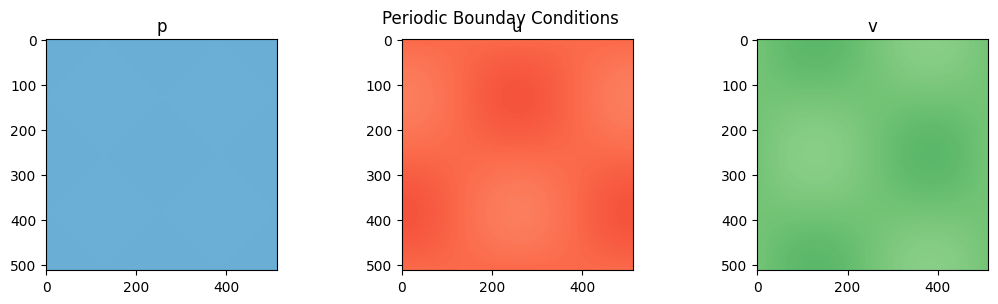

In [69]:
%matplotlib inline

# Periodic Boundary conditions

u[0, :] = u[M, :]
v[M, 1:] = v[0, 1:]
u[1:, N] = u[1:, 0]
v[:, 0] = v[:, N]

u[0, N] = u[M, 0]
v[M, 0] = v[0, N]


if VIS==True:
    if isinstance(u, real_np.ndarray):
        live_plot3(u, v, p, "Periodic Bounday Conditions")
    else:
        live_plot3(u.get(), v.get(), p.get(), "Periodic Bounday Conditions")
    
# Save initial conditions
uold = np.copy(u)
vold = np.copy(v)
pold = np.copy(p)


In [70]:
# Print initial conditions
if L_OUT:
    print(" Number of points in the x direction: ", M)
    print(" Number of points in the y direction: ", N)
    print(" grid spacing in the x direction: ", dx)
    print(" grid spacing in the y direction: ", dy)
    print(" time step: ", dt)
    print(" time filter coefficient: ", alpha)
    print(" Initial p:\n", p.diagonal()[:-1])
    print(" Initial u:\n", u.diagonal()[:-1])
    print(" Initial v:\n", v.diagonal()[:-1])
        


 Number of points in the x direction:  512
 Number of points in the y direction:  512
 grid spacing in the x direction:  100000.0
 grid spacing in the y direction:  100000.0
 time step:  90.0
 time filter coefficient:  0.001
 Initial p:
 [50000.00752991 50000.00752764 50000.00752084 50000.00750951
 50000.00749365 50000.00747328 50000.00744841 50000.00741905
 50000.00738523 50000.00734695 50000.00730425 50000.00725715
 50000.00720568 50000.00714986 50000.00708974 50000.00702535
 50000.00695673 50000.00688392 50000.00680696 50000.0067259
 50000.00664079 50000.00655168 50000.00645862 50000.00636167
 50000.00626089 50000.00615634 50000.00604808 50000.00593618
 50000.0058207  50000.00570171 50000.0055793  50000.00545352
 50000.00532445 50000.00519218 50000.00505678 50000.00491833
 50000.00477692 50000.00463264 50000.00448556 50000.00433578
 50000.00418339 50000.00402848 50000.00387115 50000.00371148
 50000.00354958 50000.00338553 50000.00321945 50000.00305143
 50000.00288157 50000.00270998 

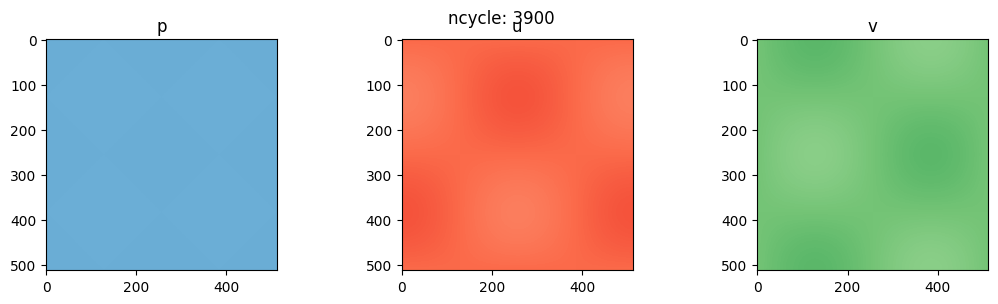

In [71]:
%matplotlib inline

time = 0.0 
# Main time loop
for ncycle in range(ITMAX):
    if((ncycle%100==0) & (VIS==False)):
        print("cycle number ", ncycle)
    # Calculate cu, cv, z, and h
    if use_naive:
        for i in range(M):
            for j in range(N):
                cu[i + 1, j] = .5 * (p[i + 1, j] + p[i, j]) * u[i + 1, j]
                cv[i, j + 1] = .5 * (p[i, j + 1] + p[i, j]) * v[i, j + 1]
                z[i + 1, j + 1] = (fsdx * (v[i + 1, j + 1] - v[i, j + 1]) -
                                fsdy * (u[i + 1, j + 1] - u[i+1, j] )
                                ) / (p[i, j] + p[i + 1, j] + p[i + 1, j + 1] + p[i, j + 1])
                h[i, j] = p[i, j] + 0.25 * (u[i + 1, j] * u[i + 1, j] + u[i, j] * u[i, j] +
                                        v[i, j + 1] * v[i, j + 1] + v[i, j] * v[i, j])
    else:
        cu[1:,:-1] = .5 * (p[1:,:-1] + p[:-1,:-1]) * u[1:,:-1]
        cv[:-1,1:] = .5 * (p[:-1,1:] + p[:-1,:-1]) * v[:-1,1:]
        z[1:,1:] = (fsdx * (v[1:,1:] - v[:-1,1:]) - fsdy * (u[1:,1:] - u[1:,:-1])) / (p[:-1,:-1] + p[1:,:-1] + p[1:,1:] + p[:-1,1:])
        h[:-1,:-1] = p[:-1,:-1] + 0.25 * (u[1:,:-1] * u[1:,:-1] + u[:-1,:-1] * u[:-1,:-1] + v[:-1,1:] * v[:-1,1:] + v[:-1,:-1] * v[:-1,:-1])
   
    # # Periodic Boundary conditions
    cu[0, :] = cu[M, :]
    h[M, :] = h[0, :]
    cv[M, 1:] = cv[0, 1:]
    z[0, 1:] = z[M, 1:]
    
    cv[:, 0] = cv[:, N]
    h[:, N] = h[:, 0]
    cu[1:, N] = cu[1:, 0]
    z[1:, N] = z[1:, 0]
        
    cu[0, N] = cu[M, 0]
    cv[M, 0] = cv[0, N]
    z[0, 0] = z[M, N]
    h[M, N] = h[0, 0]
        
    # Calclulate new values of u,v, and p
    tdts8 = tdt / 8.
    tdtsdx = tdt / dx
    tdtsdy = tdt / dy
        
    if use_naive:
        for i in range(M):
            for j in range(N):
                unew[i+1,j] = uold[i+1,j] + tdts8 * (z[i+1,j+1] + z[i+1,j]) * (cv[i+1,j+1] + cv[i+1,j] + cv[i,j+1] + cv[i,j]) - tdtsdx * (h[i+1,j] - h[i,j])
                vnew[i,j+1] = vold[i,j+1] - tdts8 * (z[i+1,j+1] + z[i,j+1]) * (cu[i+1,j+1] + cu[i+1,j] + cu[i,j+1] + cu[i,j]) - tdtsdy * (h[i,j+1] - h[i,j])
                pnew[i,j] = pold[i,j] - tdtsdx * (cu[i+1,j] - cu[i,j]) - tdtsdy * (cv[i,j+1] - cv[i,j])

    else:        
        unew[1:,:-1]=uold[1:,:-1] + tdts8 * (z[1:,1:] + z[1:,:-1]) * (cv[1:,1:] + cv[1:,:-1] + cv[:-1,1:] + cv[:-1,:-1]) - tdtsdx * (h[1:,:-1] - h[:-1,:-1])
        vnew[:-1,1:]= vold[:-1,1:] - tdts8 * (z[1:,1:] + z[:-1,1:]) * (cu[1:,1:] + cu[1:,:-1] + cu[:-1,1:] + cu[:-1,:-1]) - tdtsdy * (h[:-1,1:] - h[:-1,:-1])
        pnew[:-1,:-1] =pold[:-1,:-1] - tdtsdx * (cu[1:,:-1] - cu[:-1,:-1]) - tdtsdy * (cv[:-1,1:] - cv[:-1,:-1])
    
    # Periodic Boundary conditions
    unew[0, :] = unew[M, :]
    pnew[M, :] = pnew[0, :]
    vnew[M, 1:] = vnew[0, 1:]
    unew[1:, N] = unew[1:, 0]
    vnew[:, 0] = vnew[:, N]
    pnew[:, N] = pnew[:, 0]
    
    unew[0, N] = unew[M, 0]
    vnew[M, 0] = vnew[0, N]
    pnew[M, N] = pnew[0, 0]
    
    time = time + dt

    if(ncycle > 0):
        if use_naive:
            for i in range(M_LEN):
                for j in range(N_LEN):
                    uoldtemp=uold[i,j]
                    voldtemp=vold[i,j]
                    poldtemp=pold[i,j] 
                    uold[i,j] = u[i,j] + alpha * (unew[i,j] - 2. * u[i,j] + uoldtemp)
                    vold[i,j] = v[i,j] + alpha * (vnew[i,j] - 2. * v[i,j] + voldtemp)
                    pold[i,j] = p[i,j] + alpha * (pnew[i,j] - 2. * p[i,j] + poldtemp)
        
            for i in range(M_LEN):
                    for j in range(N_LEN):
                        u[i,j] = unew[i,j]
                        v[i,j] = vnew[i,j]
                        p[i,j] = pnew[i,j]
        else:
            uold[...]=u+alpha*(unew-2.*u+uold)
            vold[...]=v+alpha*(vnew-2.*v+vold)
            pold[...]=p+alpha*(pnew-2.*p+pold)
                                

            u[...]=unew
            v[...]=vnew
            p[...]=pnew

    else:
        tdt = tdt+tdt

        uold = np.copy(u)
        vold = np.copy(v)
        pold = np.copy(p)
        u = np.copy(unew)
        v = np.copy(vnew)
        p = np.copy(pnew)

    if((VIS == True) & (ncycle%VIS_DT==0)):
        if isinstance(u, real_np.ndarray):
            live_plot3(u, v, p, "ncycle: " + str(ncycle))
        else:
            live_plot3(u.get(), v.get(), p.get(), "ncycle: " + str(ncycle))


In [72]:
 # Print initial conditions
if L_OUT:
        print("cycle number ", ITMAX)
        print(" diagonal elements of p:\n", pnew.diagonal()[:-1])
        print(" diagonal elements of u:\n", unew.diagonal()[:-1])
        print(" diagonal elements of v:\n", vnew.diagonal()[:-1])

cycle number  4000
 diagonal elements of p:
 [50000.00752917 50000.00752603 50000.00751836 50000.00750616
 50000.00748944 50000.0074682  50000.00744247 50000.00741226
 50000.00737758 50000.00733846 50000.00729491 50000.00724698
 50000.00719467 50000.00713804 50000.0070771  50000.0070119
 50000.00694248 50000.00686888 50000.00679114 50000.00670931
 50000.00662343 50000.00653357 50000.00643977 50000.00634209
 50000.0062406  50000.00613534 50000.00602639 50000.0059138
 50000.00579766 50000.00567802 50000.00555496 50000.00542856
 50000.00529889 50000.00516602 50000.00503004 50000.00489104
 50000.00474908 50000.00460427 50000.00445668 50000.00430641
 50000.00415354 50000.00399817 50000.00384039 50000.0036803
 50000.00351799 50000.00335356 50000.00318712 50000.00301875
 50000.00284856 50000.00267666 50000.00250314 50000.00232812
 50000.00215169 50000.00197397 50000.00179506 50000.00161507
 50000.0014341  50000.00125227 50000.00106968 50000.00088645
 50000.00070269 50000.0005185  50000.000334